In [71]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io

In [72]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [73]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [74]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array = np.append(lineal_array, tmp[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return tmp, lineal_to_matrix(lineal_array)

In [75]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [76]:
def lineal_to_matrix(lineal_array):
    sqrt_ = ceil(sqrt(lineal_array.shape[0]))
    media = calculate_media_lineal_arr(lineal_array)
    missing_values = sqrt_**2 - lineal_array.shape[0]
    # Complete square matrix
    for x in range(missing_values):
        lineal_array = np.append(lineal_array, media)
    
    return lineal_array.reshape([sqrt_, sqrt_])

In [77]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [78]:
def glcm_properties(image):
    distancias = [1,2]
    #0 -> Oeste a este, #-np.pi/2 -> Sur a norte
    angulos = [0, -np.pi/2]

    # Calculate properties for just one superpixel using the
    # respective mask  
    glcm = greycomatrix(image, 
                        distances = distancias, 
                        angles = angulos,
                        symmetric=True, 
                        normed=True)
    resultadosEnergy = greycoprops(glcm, 'energy')
    resultadosHomogeneity = greycoprops(glcm, 'homogeneity')
    resultadosContrast = greycoprops(glcm, 'contrast')
    
    # Returning determinat for every matrix in order to work just with
    # 1-D arrays
    return [resultadosEnergy, resultadosHomogeneity, resultadosContrast]

In [140]:
def getROI(img, segments):
    auxiliar = [] 
    for (i, segVal) in enumerate(np.unique(segments)): #Accediendo a cada superpixel
        # construct a mask for the segment
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        mask = cv2.bitwise_and(img, img, mask = mask)
        auxiliar.append(mask) #Se agrega cada una de las mascarar
    
    #print("Función getROI, len(auxiliar) = ", len(auxiliar))
    return auxiliar

In [150]:
#Para cada máscara, segmentamos en superpixeles
def getSuperPixels(tmp):
    #aux = np.asarray(cv2.normalize(tmp, 0, 255, cv2.NORM_MINMAX), dtype=np.double)
    aux = np.asarray(cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dtype=np.double)
    segments_slic = slic(aux, n_segments = 100, compactness=0.1, sigma=0, enforce_connectivity=True, slic_zero=False)
    print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slic))}")
    
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(aux, segments_slic))
    plt.axis("off")
    plt.show()
    
    # antes tmp, segments_slic
    superpixels = np.asarray(getROI(aux, segments_slic)) #Lista de superpixeles

    res = []
    for i in range(len(superpixels)): #Iteramos sobre el número de superpixeles
        prueba = np.asarray(cv2.normalize(superpixels[i], 0, 255, cv2.NORM_MINMAX), dtype=int)
        valuePixel = np.unique(prueba)
        if (len(valuePixel) > 1):
            res.append(prueba)
    
    print("superPixels reducidos = ", len(res))
    
    return res
    
    

In [151]:
def main():
    to_show = 3
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()

    for x in range(25, 25+to_show):
        print("Image no ", x)
        classes = get_vals(masks[:,:,x])
        show_slice_mask(imgs[:,:,x], masks[:,:,x])
        for j in classes:
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            print("class ", j)
            #show_slice_mask(tmp, masks[:,:,x])
            show_slice_mask(tmp, matrix_mask)
            ###
            getSuperPixels(tmp)
            ###
            print(glcm_properties(matrix_mask.astype(np.uint8)))
            #create_matrix(tmp)
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])

Image no  25


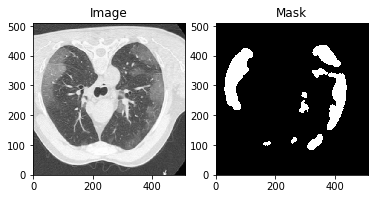

class  1.0


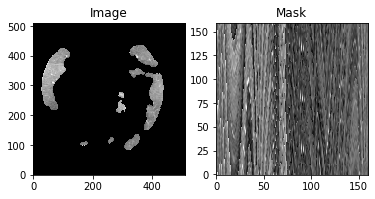

Segmentos del algoritmo SLIC: 85


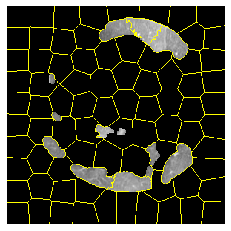

superPixels reducidos =  15
[array([[0.00795847, 0.00595827],
       [0.00679977, 0.00593684]]), array([[0.05140663, 0.01397761],
       [0.02981182, 0.01230585]]), array([[ 4560.19732704, 10017.42036164],
       [ 6778.47432753, 10405.93496835]])]
Image no  26


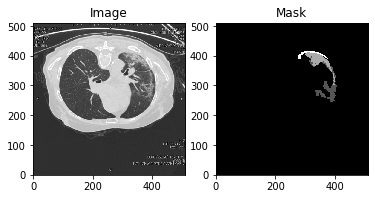

class  3.0


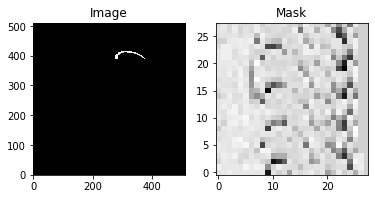

Segmentos del algoritmo SLIC: 99


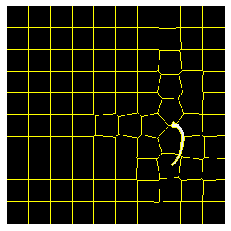

superPixels reducidos =  1
[array([[0.08211719, 0.05724626],
       [0.07955183, 0.04779154]]), array([[0.11239955, 0.09041826],
       [0.11321408, 0.04731954]]), array([[16414.3968254 , 16968.39814815],
       [17080.67445055, 17292.94505495]])]
class  2.0


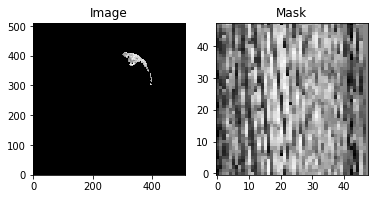

Segmentos del algoritmo SLIC: 99


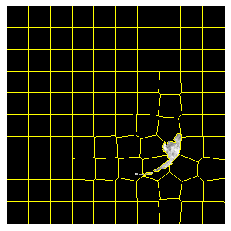

superPixels reducidos =  2
[array([[0.0315978 , 0.01832181],
       [0.03039823, 0.01790239]]), array([[0.05148818, 0.01988923],
       [0.04498262, 0.013601  ]]), array([[ 9490.8962766 , 10695.1498227 ],
       [10598.50634058, 10645.39402174]])]
class  1.0


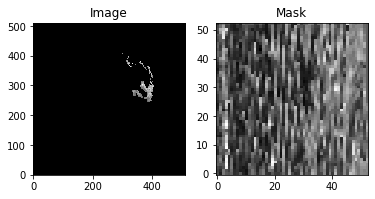

Segmentos del algoritmo SLIC: 100


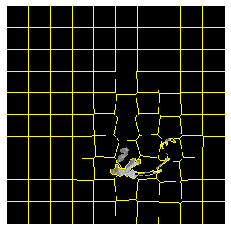

superPixels reducidos =  5
[array([[0.0247081 , 0.01764933],
       [0.02162126, 0.0178503 ]]), array([[0.05392107, 0.01839977],
       [0.03283184, 0.01543907]]), array([[ 9185.29535559, 11740.49637155],
       [11354.16056234, 11767.28079911]])]
Image no  27


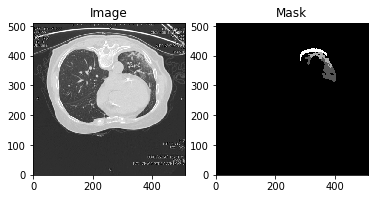

class  3.0


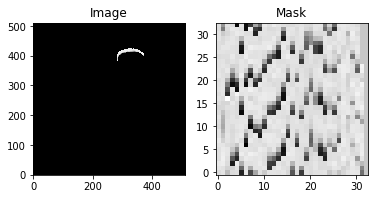

Segmentos del algoritmo SLIC: 99


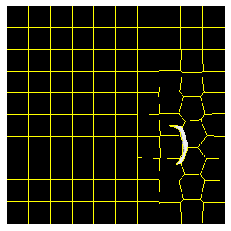

superPixels reducidos =  3
[array([[0.07019084, 0.04868382],
       [0.06310098, 0.0491099 ]]), array([[0.11821719, 0.06027719],
       [0.08094126, 0.04301846]]), array([[16347.14299242, 20045.89867424],
       [20376.01857283, 20704.59139785]])]
class  1.0


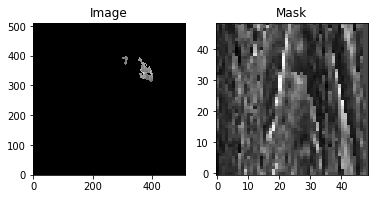

Segmentos del algoritmo SLIC: 99


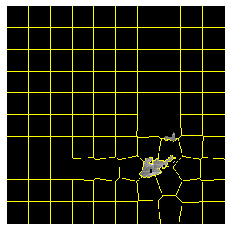

superPixels reducidos =  3
[array([[0.03928972, 0.02315323],
       [0.03641985, 0.0212167 ]]), array([[0.09147375, 0.03510773],
       [0.05186471, 0.02467606]]), array([[ 6663.22066327,  9624.50382653],
       [ 8325.47980894, 10663.88276162]])]
class  2.0


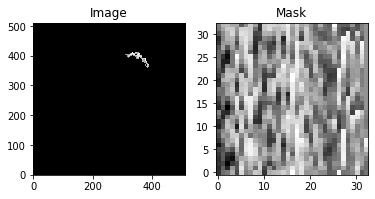

Segmentos del algoritmo SLIC: 98


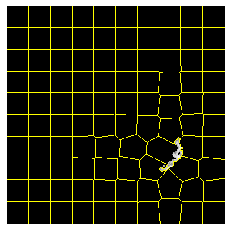

superPixels reducidos =  2
[array([[0.03053151, 0.02356985],
       [0.0294231 , 0.02417256]]), array([[0.04154641, 0.01188668],
       [0.03243551, 0.00931041]]), array([[10094.19412879, 10677.97159091],
       [10489.86803519, 10544.12609971]])]


In [152]:
main()

# SEGMENTACIÓN USANDO SUPERPÍXELES

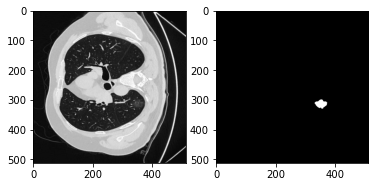

In [16]:
imgs = nib.load(images_filename).get_fdata()
masks = nib.load(masks_filename).get_fdata()
fig, ax = plt.subplots(1,2)
ax[0].imshow(imgs[:,:,2],cmap="gray")
ax[1].imshow(masks[:,:,2],cmap="gray")

In [17]:
#funcion para segmentar superpíxeles
def SLIC(img, k):
    image = img_as_float(img)

    segments = slic(image, k, sigma = 5)
    # show the output of SLIC
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


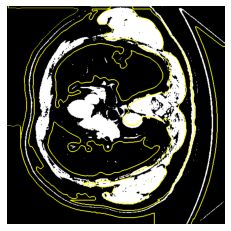

In [18]:
SLIC(imgs[:,:,2],20) #El 100 es el coef de superpíxeles